In [ ]:
import torch
print(torch.cuda.device_count())

1


In [ ]:
!sudo apt-get update -y
!sudo apt-get install python3
!sudo apt-get update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,974 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,566 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import os
import timeit
from datetime import datetime
import socket
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
#learning_rates = [1e-3, 5e-4, 1e-4]

In [ ]:
# read_data.py
import cv2
import os
import numpy as np
import torch
from PIL import Image

class Dashcam_data:
    def __init__(self, dataset='Dashcam', dir='/content/drive/MyDrive/G13_ML', batch_size=64, frame_size=[112, 112], train="train"):
        self.dataset = dataset
        self.dir = dir
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.train = train
        if self.train == "train":
            self.positive_path = "/content/drive/MyDrive/G13_ML/training/Positive"
            self.negative_path = "/content/drive/MyDrive/G13_ML/training/Negative"
        else:
            self.test_path = "/content/drive/MyDrive/G13_ML/testing"
        self.video_paths = []
        self.labels = []
        self._load_video_paths()
        self.total_folders = len(self.video_paths)

    def _load_video_paths(self):
        if self.train == "train":
        # Training data loading remains the same
            for video in os.listdir(self.positive_path):
                if video.endswith('.mp4'):
                    self.video_paths.append(os.path.join(self.positive_path, video))
                    self.labels.append(1)
            for video in os.listdir(self.negative_path):
                if video.endswith('.mp4'):
                    self.video_paths.append(os.path.join(self.negative_path, video))
                    self.labels.append(0)
        else:
            # Modified test data loading
            for class_folder in os.listdir(self.test_path):
                class_path = os.path.join(self.test_path, class_folder)
                if os.path.isdir(class_path):
                    label = 1 if class_folder.lower() == "positive" else 0
                    for video in os.listdir(class_path):
                        if video.endswith('.mp4'):
                            self.video_paths.append(os.path.join(class_path, video))
                            self.labels.append(label)

    def _extract_frames(self, video_path, clip_len):
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if frame_count < clip_len:
            raise ValueError(f"Video {video_path} has fewer frames than required clip length")

        start_frame = np.random.randint(0, frame_count - clip_len)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(clip_len):
           ret, frame = cap.read()
           if not ret:
                raise ValueError(f"Failed to read frame from video {video_path}")
           frame = cv2.resize(frame, (self.frame_size[0], self.frame_size[1]))
           frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
           frame = frame / 255.0  # Normalize
           frames.append(frame)

        cap.release()
        return np.array(frames)

    def get_next_batch(self, batch_size, clip_len):
        batch = np.zeros((batch_size, clip_len, self.frame_size[0], self.frame_size[1], 3))
        labels = np.zeros(batch_size)

        for i in range(batch_size):
            video_index = np.random.randint(0, len(self.video_paths))
            video_path = self.video_paths[video_index]
            label = self.labels[video_index]

            frames = self._extract_frames(video_path, clip_len)
            batch[i] = frames
            labels[i] = label

        batch = np.transpose(batch, (0, 4, 1, 2, 3))  # Change to (N, C, T, H, W) format for PyTorch
        return torch.from_numpy(batch).float(), torch.from_numpy(labels).long()

In [ ]:
def custom_weight_init(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [ ]:
import torch
import torch.nn as nn
#from mypath import Path
from torch.autograd import Variable
import os

class C3D_model(nn.Module):
    def __init__(self, num_classes):
        super(C3D_model, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))
        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

        self.apply(custom_weight_init)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)
        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        x = x.reshape(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)
        logits = self.fc8(x)
        return logits


if __name__ == "__main__":


    p = "/content/drive/MyDrive/G13_ML/testing/Frames/Positive"
    for filename in os.listdir(p):
        path = p + "/"+ filename

        for file in os.listdir(path):
            old_path = path + "/" + file
            q = os.path.split(old_path)
            image = q[-1][:-4]

            image = image.zfill(3)

            new_path = path +"/"+image+".jpg"

            os.rename(old_path,new_path)

In [ ]:
def get_1x_lr_params(model):
    """
    This generator returns all the parameters for conv and two fc layers of the net.
    """
    b = [model.conv1, model.conv2, model.conv3a, model.conv3b, model.conv4a, model.conv4b,
         model.conv5a, model.conv5b, model.fc6, model.fc7]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k

def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last fc layer of the net.
    """
    b = [model.fc8]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [ ]:
def train_C3D(args):
    device = args.device
    print("Device being used:", device)

    save_dir_root = "./"
    save_dir = os.path.join(save_dir_root, 'run', 'run_0')
    saveName = args.modelName + '-' + args.dataset

    model = C3D_model(num_classes=2).to(device)
    train_params = [{'params': get_1x_lr_params(model), 'lr': args.lr},
                    {'params': get_10x_lr_params(model), 'lr': args.lr * 10}]
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(train_params, lr=args.lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    if args.resume_epoch != 0:
        checkpoint_path = os.path.join(save_dir, 'models', saveName + '_epoch-' + str(args.resume_epoch - 1) + '.pth.tar')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['opt_dict'])
            print("Initializing weights from: {}...".format(checkpoint_path))
        else:
            print(f"Checkpoint not found: {checkpoint_path}. Training from scratch.")
    else:
        print("Training {} from scratch...".format('C3D'))

    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
    writer = SummaryWriter(log_dir=log_dir)
    print('Training model on {} dataset...'.format(args.dataset))

    train = Dashcam_data(train='train')
    step = 0

    for epoch in range(args.resume_epoch, args.epochs):
        for phase in ['train']:
            start_time = timeit.default_timer()
            running_loss = 0.0
            running_corrects = 0.0
            dataset = train
            scheduler.step()
            model.train()
            im_names = dataset.total_folders
            tot_batches = int(im_names / args.batch_size)

            for i in range(tot_batches):
                inputs, labels = dataset.get_next_batch(args.batch_size, args.clip_len)
                inputs = Variable(inputs).to(device)
                labels = Variable(labels).to(device)
                optimizer.zero_grad()
                k = inputs
                for j in range(args.clip_len - 1):
                    k[:, :, j, :, :] = inputs[:, :, j + 1, :, :] - inputs[:, :, j, :, :]
                loss1 = torch.mean(torch.mean(torch.mean(torch.mean(torch.mean(k, dim=1), dim=1), dim=1), dim=1), dim=0)
                outputs = model(inputs)
                probs = nn.Softmax(dim=1)(outputs)
                preds = torch.max(probs, 1)[1]
                loss = criterion(outputs, labels)
                loss = loss + loss1
                print(loss.item())
                if (i + 1) % 10 == 0:
                    print("Epoch", epoch, "Batch done ", i, "out of", tot_batches)
                    print("loss is ", loss.item())
                writer.add_scalar('data/train_loss_batch', loss.item(), step)
                step += 1
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / im_names
            epoch_acc = (running_corrects.item() / im_names) * 100
            if phase == 'train':
                writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
                writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
            print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format(phase, epoch + 1, args.epochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

            if epoch % args.snapshot == (args.snapshot - 1):
                os.makedirs('./models', exist_ok=True)
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'opt_dict': optimizer.state_dict(),
                }, os.path.join('./models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
                print("Save model at {}\n".format(
                    os.path.join('./models', saveName + '_epoch-' + str(epoch)  + '.pth.tar')))

        writer.close()

In [ ]:
import glob

def test_C3D(args):
    device = args.device
    print("Device being used:", device)
    model = C3D_model(num_classes=2).to(device)

    dataset = Dashcam_data(train='test')

    # Check class distribution
    class_counts = {0: 0, 1: 0}
    for label in dataset.labels:
        class_counts[label] += 1

    print("Class distribution in test dataset:")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count} samples")

    # Find the latest checkpoint
    checkpoint_dir = "./models"
    checkpoint_pattern = "C3D-dashcam_epoch-*.pth.tar"
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, checkpoint_pattern))

    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
        print(f"Loading the latest checkpoint: {latest_checkpoint}")

        checkpoint = torch.load(latest_checkpoint, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
    else:
        print(f"No checkpoint found in {checkpoint_dir}. Cannot perform testing.")
        return

    criterion = nn.CrossEntropyLoss().to(device)
    dataset = Dashcam_data(train='test')
    im_names = dataset.total_folders
    tot_batches = int(im_names / args.batch_size)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(tot_batches):
            inputs, labels = dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Calculate F1-score using torcheval
    f1_torcheval = multiclass_f1_score(torch.tensor(all_preds), torch.tensor(all_labels), num_classes=2, average='weighted')

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score (sklearn): {f1:.4f}")
    print(f"F1-score (torcheval): {f1_torcheval:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

In [ ]:
config = {
    'epochs': 50,
    'Train': True,
    'continue_training': True,
    'model': "checkpoint",
    'lr': 1e-3,
    'batch_size': 2,
    'clip_len': 16,
    'resume_epoch': 0,
    'dataset': "dashcam",
    'save_dir': "logs",
    'save_epoch': 10,
    'snapshot': 1,
    'num_classes': 2,
    'modelName': "C3D",
    'useTest': False,
    'nTestInterval': 2
}
args = type('Args', (), config)()

# Use the correct device
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {args.device}")

if args.Train:
        print("Starting training...")
        train_C3D(args)
        print("Training completed.")

print("Starting testing...")
test_C3D(args)
print("Testing completed.")

Device being used: cuda
Starting training...
Device being used: cuda
Training C3D from scratch...
Total params: 78.00M
Training model on dashcam dataset...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0.7093884348869324
0.7164356708526611
0.701082706451416
0.7062448859214783
0.698129415512085
0.71275794506073
0.6751103401184082
0.6481963992118835
0.7087386846542358
0.7242605090141296
Epoch 0 Batch done  9 out of 50
loss is  0.7242605090141296
0.7118498682975769
0.7343352437019348
0.8623208403587341
0.851189911365509
0.7215830683708191
0.7221863865852356
0.812821626663208
0.8317389488220215
0.7911092042922974
0.707277774810791
Epoch 0 Batch done  19 out of 50
loss is  0.707277774810791
0.664202868938446
0.7145577669143677
0.6901072859764099
0.7352872490882874
0.7235433459281921
0.7231178283691406
0.7024866938591003
0.6997207403182983
0.685077965259552
0.7787096500396729
Epoch 0 Batch done  29 out of 50
loss is  0.7787096500396729
0.7828644514083862
0.7793178558349609
0.7668029069900513
0.6579611897468567
0.7644463181495667
0.7142007946968079
0.6924622058868408
0.724904477596283
0.691960871219635
0.6714257001876831
Epoch 0 Batch done  39 out of 50
loss is  0.6714257001876831
0.7623596

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from torcheval.metrics.functional import multiclass_f1_score

def train_model(args, model, train_dataset, val_dataset, criterion, optimizer, scheduler):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(args.epochs):
        model.train()
        train_loss, train_acc = train_epoch_C3D(args, model, train_dataset, criterion, optimizer)

        model.eval()
        val_loss, val_acc = validate_epoch_C3D(args, model, val_dataset, criterion)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{args.epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

def train_epoch_C3D(args, model, dataset, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    total_samples = 0

    for i in range(int(dataset.total_folders / args.batch_size)):
        inputs, labels = dataset.get_next_batch(args.batch_size, args.clip_len)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (running_corrects.item() / total_samples) * 100

    return epoch_loss, epoch_acc

def validate_epoch_C3D(args, model, dataset, criterion):
    running_loss = 0.0
    running_corrects = 0.0
    total_samples = 0

    with torch.no_grad():
        for i in range(int(dataset.total_folders / args.batch_size)):
            inputs, labels = dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (running_corrects.item() / total_samples) * 100

    return epoch_loss, epoch_acc

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = Dashcam_data(train='train')
    val_dataset = Dashcam_data(train='test')  # Using test set as validation set
    test_dataset = Dashcam_data(train='test')

    # Use predefined parameters instead of hyperparameter tuning
    best_params = {
        'lr': 1e-2,
        'batch_size': 16,
        'hidden_size': 256  # for GRU model
    }
    print("Using parameters:", best_params)

    args = type('Args', (), {
        'epochs': 50,
        'clip_len': 16,
        'num_classes': 2,
        'dataset': 'dashcam',
        'input_size': 3 * 112 * 112,  # for GRU model
        **best_params
    })()

    # Choose the model you want to use (C3D or GRU)
    model = C3D_model(num_classes=args.num_classes).to(device)
    # Or for GRU:
    # model = GRU_model(args.input_size, args.hidden_size, args.num_classes).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model
    train_losses, val_losses, train_accs, val_accs = train_model(args, model, train_dataset, val_dataset, criterion, optimizer, scheduler)

Using parameters: {'lr': 0.01, 'batch_size': 16, 'hidden_size': 256}
Epoch 1/50
Train Loss: 0.6920, Train Acc: 57.29%
Val Loss: 0.6933, Val Acc: 46.88%
Epoch 2/50
Train Loss: 0.6933, Train Acc: 51.04%
Val Loss: 0.6917, Val Acc: 56.25%
Epoch 3/50
Train Loss: 0.6985, Train Acc: 52.08%
Val Loss: 0.6909, Val Acc: 54.17%
Epoch 4/50
Train Loss: 0.6888, Train Acc: 50.00%
Val Loss: 0.6932, Val Acc: 50.00%
Epoch 5/50
Train Loss: 0.6932, Train Acc: 50.00%
Val Loss: 0.6874, Val Acc: 55.21%
Epoch 6/50
Train Loss: 0.6944, Train Acc: 50.00%
Val Loss: 0.6998, Val Acc: 42.71%
Epoch 7/50
Train Loss: 0.6916, Train Acc: 48.96%
Val Loss: 0.6941, Val Acc: 46.88%
Epoch 8/50
Train Loss: 0.6916, Train Acc: 61.46%
Val Loss: 0.6904, Val Acc: 53.12%
Epoch 9/50
Train Loss: 0.6867, Train Acc: 57.29%
Val Loss: 0.6887, Val Acc: 58.33%
Epoch 10/50
Train Loss: 0.6938, Train Acc: 57.29%
Val Loss: 0.7042, Val Acc: 47.92%
Epoch 11/50
Train Loss: 0.6988, Train Acc: 48.96%
Val Loss: 0.7037, Val Acc: 43.75%
Epoch 12/50
Trai

In [ ]:
def plot_convergence_C3D(train_losses, val_losses, train_accs, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_convergence_plot.png')
    plt.show()


In [ ]:
def test_C3D(args, model, test_dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(int(test_dataset.total_folders / args.batch_size)):
            inputs, labels = test_dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / test_dataset.total_folders
    test_acc = (running_corrects.item() / test_dataset.total_folders) * 100

    return test_loss, test_acc, all_preds, all_labels


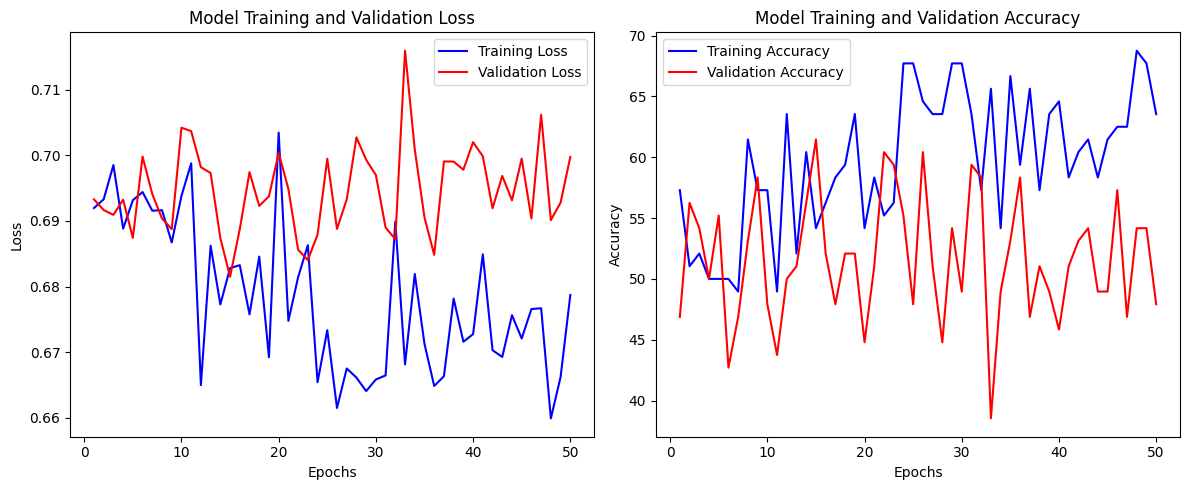


Test Results:
Test Loss: 0.6767
Test Accuracy: 46.00%
Precision: 0.4823
Recall: 0.4792
F1-score: 0.4805

Confusion Matrix:
[[17 24]
 [26 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.41      0.40        41
           1       0.55      0.53      0.54        55

    accuracy                           0.48        96
   macro avg       0.47      0.47      0.47        96
weighted avg       0.48      0.48      0.48        96



In [ ]:
# Plot convergence
plot_convergence_C3D(train_losses, val_losses, train_accs, val_accs, "Model")

# Test the model
criterion = nn.CrossEntropyLoss().to(device)
test_loss, test_acc, all_preds, all_labels = test_C3D(args, model, test_dataset, device, criterion)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

    # Calculate and print additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import os
import timeit
from datetime import datetime
import socket
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from torcheval.metrics.functional import multiclass_f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterSampler

# Assuming Dashcam_data class is already implemented

class GRU_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU_model, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, channels, frames, height, width = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(batch_size, frames, -1)
        _, hidden = self.gru(x)
        output = self.fc(hidden.squeeze(0))
        return output

In [10]:
def test_gru(args, model, test_dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(int(test_dataset.total_folders / args.batch_size)):
            inputs, labels = test_dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / test_dataset.total_folders
    epoch_acc = (running_corrects.item() / test_dataset.total_folders) * 100

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    f1_torcheval = multiclass_f1_score(torch.tensor(all_preds), torch.tensor(all_labels), num_classes=2, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, f1_torcheval, cm, all_labels, all_preds


In [ ]:
def main():
    config = {
        'epochs': 1,
        'Train': True,
        'continue_training': True,
        'model': "checkpoint",
        'lr': 1e-3,
        'batch_size': 2,
        'clip_len': 16,
        'resume_epoch': 0,
        'dataset': "dashcam",
        'save_dir': "logs",
        'save_epoch': 10,
        'snapshot': 1,
        'num_classes': 2,
        'modelName': "GRU",
        'useTest': False,
        'nTestInterval': 2
    }

    args = type('Args', (), config)()
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device being used: {args.device}")

    if args.Train:
        print("Starting training...")
        train_and_test_gru(args)
        print("Training completed.")

    print("Starting testing...")
    train_and_test_gru(args)
    print("Testing completed.")

Epoch 1/3
Batch 0 out of 6, Loss: 0.8024802207946777
Train Loss: 0.9407, Train Acc: 53.0000
Test Loss: 0.7705, Test Acc: 41.0000
Time: 47.44s
Epoch 2/3
Batch 0 out of 6, Loss: 0.6820091009140015
Train Loss: 0.6651, Train Acc: 51.0000
Test Loss: 0.6746, Test Acc: 49.0000
Time: 43.16s
Epoch 3/3
Batch 0 out of 6, Loss: 0.691804826259613
Train Loss: 0.6553, Train Acc: 53.0000
Test Loss: 0.6670, Test Acc: 52.0000
Time: 40.77s

Confusion Matrix:
[[50  7]
 [37  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.88      0.69        57
           1       0.22      0.05      0.08        39

    accuracy                           0.54        96
   macro avg       0.40      0.46      0.39        96
weighted avg       0.43      0.54      0.45        96

Precision: 0.4315
Recall: 0.5417
F1-score: 0.4462


In [8]:
def train_gru(args, model, train_dataset, device, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0

    for i in range(int(train_dataset.total_folders / args.batch_size)):
        inputs, labels = train_dataset.get_next_batch(args.batch_size, args.clip_len)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_dataset.total_folders
    epoch_acc = (running_corrects.item() / train_dataset.total_folders) * 100
    scheduler.step()

    return epoch_loss, epoch_acc

def validate_gru(args, model, val_dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    with torch.no_grad():
        for i in range(int(val_dataset.total_folders / args.batch_size)):
            inputs, labels = val_dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / val_dataset.total_folders
    epoch_acc = (running_corrects.item() / val_dataset.total_folders) * 100

    return epoch_loss, epoch_acc

def test_gru(args, model, test_dataset, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(int(test_dataset.total_folders / args.batch_size)):
            inputs, labels = test_dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    f1_torcheval = multiclass_f1_score(torch.tensor(all_preds), torch.tensor(all_labels), num_classes=2, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, f1_torcheval, cm, all_labels, all_preds

def random_search_gru(train_dataset, val_dataset, test_dataset, num_trials=10):
    param_distributions = {
        'lr': [1e-4, 1e-3, 1e-2],
        'batch_size': [16, 32, 64],
        'hidden_size': [128, 256, 512]
    }

    param_list = list(ParameterSampler(param_distributions, n_iter=num_trials))

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_list:
        args = type('Args', (), {
            'epochs': 10,
            'clip_len': 16,
            'num_classes': 2,
            'dataset': 'dashcam',
            'input_size': 3 * 112 * 112,
            **params
        })()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = GRU_model(args.input_size, params['hidden_size'], args.num_classes).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        train_losses, val_losses, train_accs, val_accs = [], [], [], []

        for epoch in range(args.epochs):
            train_loss, train_acc = train_gru(args, model, train_dataset, device, criterion, optimizer, scheduler)
            val_loss, val_acc = validate_gru(args, model, val_dataset, device, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{args.epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            best_params = params
            best_model = model

        plot_convergence(train_losses, val_losses, train_accs, val_accs, f"GRU_lr{params['lr']}_batch{params['batch_size']}_hidden{params['hidden_size']}")

    # Test the best model
    accuracy, precision, recall, f1, f1_torcheval, cm = test_gru(args, best_model, test_dataset, device, criterion)

    print("\nBest Hyperparameters:", best_params)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score (sklearn): {f1:.4f}")
    print(f"F1-score (torcheval): {f1_torcheval:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

def plot_convergence(train_losses, val_losses, train_accs, val_accs, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{title}_convergence_plot.png')
    plt.close()

if __name__ == "__main__":
    train_dataset = Dashcam_data(train='train')
    val_dataset = Dashcam_data(train='test')  # Using test set as validation set
    test_dataset = Dashcam_data(train='test')

    random_search_gru(train_dataset, val_dataset, test_dataset)


Epoch 1/10
Train Loss: 0.5329, Train Acc: 27.00%
Val Loss: 1.3737, Val Acc: 30.00%
Epoch 2/10
Train Loss: 0.9691, Train Acc: 40.00%
Val Loss: 1.1309, Val Acc: 28.00%
Epoch 3/10
Train Loss: 0.9502, Train Acc: 33.00%
Val Loss: 0.8846, Val Acc: 30.00%
Epoch 4/10
Train Loss: 0.8194, Train Acc: 31.00%
Val Loss: 0.6833, Val Acc: 32.00%
Epoch 5/10
Train Loss: 0.6947, Train Acc: 31.00%
Val Loss: 0.5704, Val Acc: 36.00%
Epoch 6/10
Train Loss: 0.5982, Train Acc: 31.00%
Val Loss: 0.5649, Val Acc: 36.00%
Epoch 7/10
Train Loss: 0.4089, Train Acc: 44.00%
Val Loss: 0.5862, Val Acc: 32.00%
Epoch 8/10
Train Loss: 0.4681, Train Acc: 38.00%
Val Loss: 0.6007, Val Acc: 32.00%
Epoch 9/10
Train Loss: 0.4681, Train Acc: 36.00%
Val Loss: 0.5494, Val Acc: 35.00%
Epoch 10/10
Train Loss: 0.5072, Train Acc: 33.00%
Val Loss: 0.5584, Val Acc: 32.00%
Epoch 1/10
Train Loss: 0.8134, Train Acc: 48.00%
Val Loss: 0.8447, Val Acc: 43.00%
Epoch 2/10
Train Loss: 0.7809, Train Acc: 48.00%
Val Loss: 0.7148, Val Acc: 46.00%
Epo

NameError: name 'all_labels' is not defined

In [11]:
if __name__ == "__main__":
    train_dataset = Dashcam_data(train='train')
    val_dataset = Dashcam_data(train='test')  # Using test set as validation set
    test_dataset = Dashcam_data(train='test')

    # Use the best hyperparameters found in the previous run
    best_params = {'lr': 0.01, 'hidden_size': 512, 'batch_size': 16}

    args = type('Args', (), {
        'epochs': 10,
        'clip_len': 16,
        'num_classes': 2,
        'dataset': 'dashcam',
        'input_size': 3 * 112 * 112,
        **best_params
    })()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GRU_model(args.input_size, best_params['hidden_size'], args.num_classes).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model with the best hyperparameters
    for epoch in range(args.epochs):
        train_loss, train_acc = train_gru(args, model, train_dataset, device, criterion, optimizer, scheduler)
        val_loss, val_acc = validate_gru(args, model, val_dataset, device, criterion)

        print(f"Epoch {epoch+1}/{args.epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Test the model
    accuracy, precision, recall, f1, f1_torcheval, cm, all_labels, all_preds = test_gru(args, model, test_dataset, device, criterion)

    print("\nTest Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score (sklearn): {f1:.4f}")
    print(f"F1-score (torcheval): {f1_torcheval:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


Epoch 1/10
Train Loss: 0.7936, Train Acc: 55.00%
Val Loss: 0.7937, Val Acc: 45.00%
Epoch 2/10
Train Loss: 0.5864, Train Acc: 59.00%
Val Loss: 0.7165, Val Acc: 59.00%
Epoch 3/10
Train Loss: 0.6034, Train Acc: 58.00%
Val Loss: 0.7506, Val Acc: 52.00%
Epoch 4/10
Train Loss: 0.5722, Train Acc: 65.00%
Val Loss: 0.7919, Val Acc: 50.00%
Epoch 5/10
Train Loss: 0.6008, Train Acc: 60.00%
Val Loss: 0.9575, Val Acc: 43.00%
Epoch 6/10
Train Loss: 0.5851, Train Acc: 60.00%
Val Loss: 0.8265, Val Acc: 47.00%
Epoch 7/10
Train Loss: 0.6008, Train Acc: 56.00%
Val Loss: 0.8247, Val Acc: 43.00%
Epoch 8/10
Train Loss: 0.5577, Train Acc: 60.00%
Val Loss: 0.8643, Val Acc: 46.00%
Epoch 9/10
Train Loss: 0.5936, Train Acc: 53.00%
Val Loss: 0.8174, Val Acc: 47.00%
Epoch 10/10
Train Loss: 0.5314, Train Acc: 69.00%
Val Loss: 0.8141, Val Acc: 47.00%

Test Results:
Test Accuracy: 0.5312
Precision: 0.5316
Recall: 0.5312
F1-score (sklearn): 0.5300
F1-score (torcheval): 0.5300

Confusion Matrix:
[[23 25]
 [20 28]]

Clas

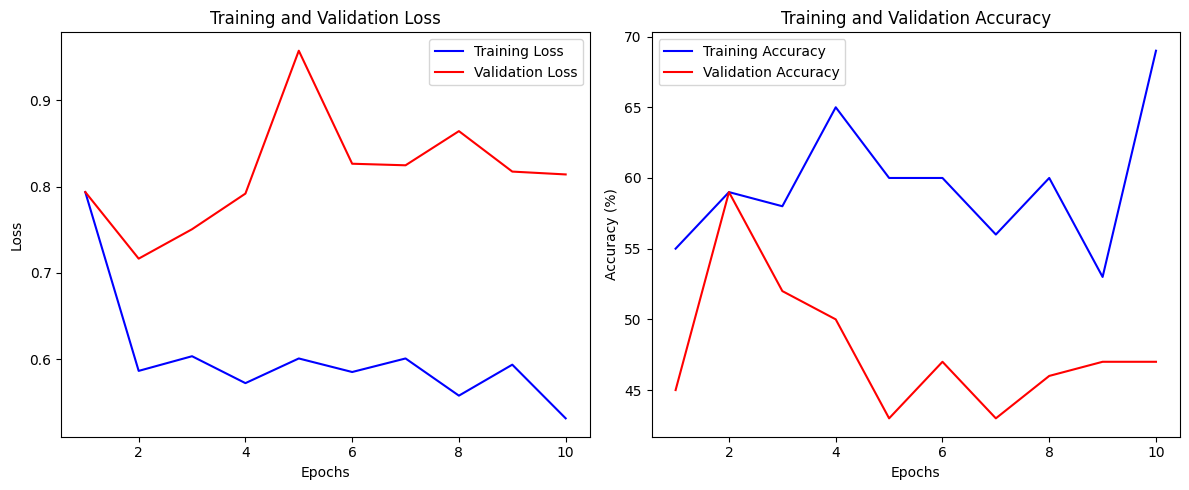

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, 11)  # 10 epochs

train_loss = [0.7936, 0.5864, 0.6034, 0.5722, 0.6008, 0.5851, 0.6008, 0.5577, 0.5936, 0.5314]
train_acc = [55.00, 59.00, 58.00, 65.00, 60.00, 60.00, 56.00, 60.00, 53.00, 69.00]
val_loss = [0.7937, 0.7165, 0.7506, 0.7919, 0.9575, 0.8265, 0.8247, 0.8643, 0.8174, 0.8141]
val_acc = [45.00, 59.00, 52.00, 50.00, 43.00, 47.00, 43.00, 46.00, 47.00, 47.00]

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


CNN-GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from torcheval.metrics.functional import multiclass_f1_score

class CNN_GRU_model(nn.Module):
    def __init__(self, num_classes=2, activation='relu'):
        super(CNN_GRU_model, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.gru = nn.GRU(256 * 7 * 7, 512, batch_first=True)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, x):
        batch_size, channels, frames, height, width = x.size()

        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.pool2(x)
        x = self.activation(self.conv3(x))
        x = self.pool3(x)

        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(batch_size, frames, -1)

        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take the last output of GRU
        x = self.dropout(x)
        x = self.fc(x)

        return x

def train_cnn_gru(args, model, train_dataset, device, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0

    for i in range(int(train_dataset.total_folders / args.batch_size)):
        inputs, labels = train_dataset.get_next_batch(args.batch_size, args.clip_len)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if (i % 10) == 0:
            print(f"Batch {i} out of {int(train_dataset.total_folders / args.batch_size)}, Loss: {loss.item()}")

    epoch_loss = running_loss / train_dataset.total_folders
    epoch_acc = (running_corrects.item() / train_dataset.total_folders) * 100
    scheduler.step()

    return epoch_loss, epoch_acc

def test_cnn_gru(args, model, test_dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(int(test_dataset.total_folders / args.batch_size)):
            inputs, labels = test_dataset.get_next_batch(args.batch_size, args.clip_len)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / test_dataset.total_folders
    epoch_acc = (running_corrects.item() / test_dataset.total_folders) * 100

    return epoch_loss, epoch_acc, all_preds, all_labels

def train_and_evaluate(optimizer_name, activation, learning_rate, num_runs=5):
    results = []
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs} - Optimizer: {optimizer_name}, Activation: {activation}, Learning Rate: {learning_rate}")

        model = CNN_GRU_model(num_classes=args.num_classes, activation=activation).to(device)
        criterion = nn.CrossEntropyLoss().to(device)

        if optimizer_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        else:
            raise ValueError("Unsupported optimizer")

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        train_dataset = Dashcam_data(train='train')
        test_dataset = Dashcam_data(train='test')

        best_accuracy = 0
        for epoch in range(args.epochs):
            train_loss, train_acc = train_cnn_gru(args, model, train_dataset, device, criterion, optimizer, scheduler)
            test_loss, test_acc, _, _ = test_cnn_gru(args, model, test_dataset, device, criterion)

            if test_acc > best_accuracy:
                best_accuracy = test_acc

            print(f"Epoch {epoch+1}/{args.epochs} - Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        results.append(best_accuracy)

    return results

# Main execution
if __name__ == "__main__":
    args = type('Args', (), {
        'epochs': 10,
        'batch_size': 16,
        'clip_len': 16,
        'num_classes': 2,
    })()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    configurations = [
        ('adam', 'relu', 0.001),
        ('adam', 'sigmoid', 0.001),
        ('sgd', 'relu', 0.001),
        ('sgd', 'sigmoid', 0.001)
    ]

    all_results = {}

    for optimizer, activation, lr in configurations:
        results = train_and_evaluate(optimizer, activation, lr)
        all_results[f"{optimizer}_{activation}"] = results
        print(f"Results for {optimizer} optimizer with {activation} activation:")
        print(f"Mean accuracy: {np.mean(results):.2f}% (+/- {np.std(results):.2f}%)")
        print("Individual runs:", results)
        print()

Run 1/5 - Optimizer: adam, Activation: relu, Learning Rate: 0.001
Batch 0 out of 6, Loss: 0.6841722130775452
Epoch 1/10 - Train Acc: 59.00%, Test Acc: 45.00%
Batch 0 out of 6, Loss: 0.7635480165481567
Epoch 2/10 - Train Acc: 49.00%, Test Acc: 42.00%
Batch 0 out of 6, Loss: 0.6754654049873352
Epoch 3/10 - Train Acc: 49.00%, Test Acc: 53.00%
Batch 0 out of 6, Loss: 0.6755361557006836
Epoch 4/10 - Train Acc: 47.00%, Test Acc: 44.00%
Batch 0 out of 6, Loss: 0.704838752746582
Epoch 5/10 - Train Acc: 45.00%, Test Acc: 50.00%
Batch 0 out of 6, Loss: 0.6952756643295288
Epoch 6/10 - Train Acc: 47.00%, Test Acc: 48.00%
Batch 0 out of 6, Loss: 0.6937165260314941
Epoch 7/10 - Train Acc: 57.00%, Test Acc: 51.00%
Batch 0 out of 6, Loss: 0.6930989027023315
Epoch 8/10 - Train Acc: 58.00%, Test Acc: 60.00%
Batch 0 out of 6, Loss: 0.6530153751373291
Epoch 9/10 - Train Acc: 60.00%, Test Acc: 48.00%
Batch 0 out of 6, Loss: 0.7648113965988159
Epoch 10/10 - Train Acc: 56.00%, Test Acc: 41.00%
Run 2/5 - Opti

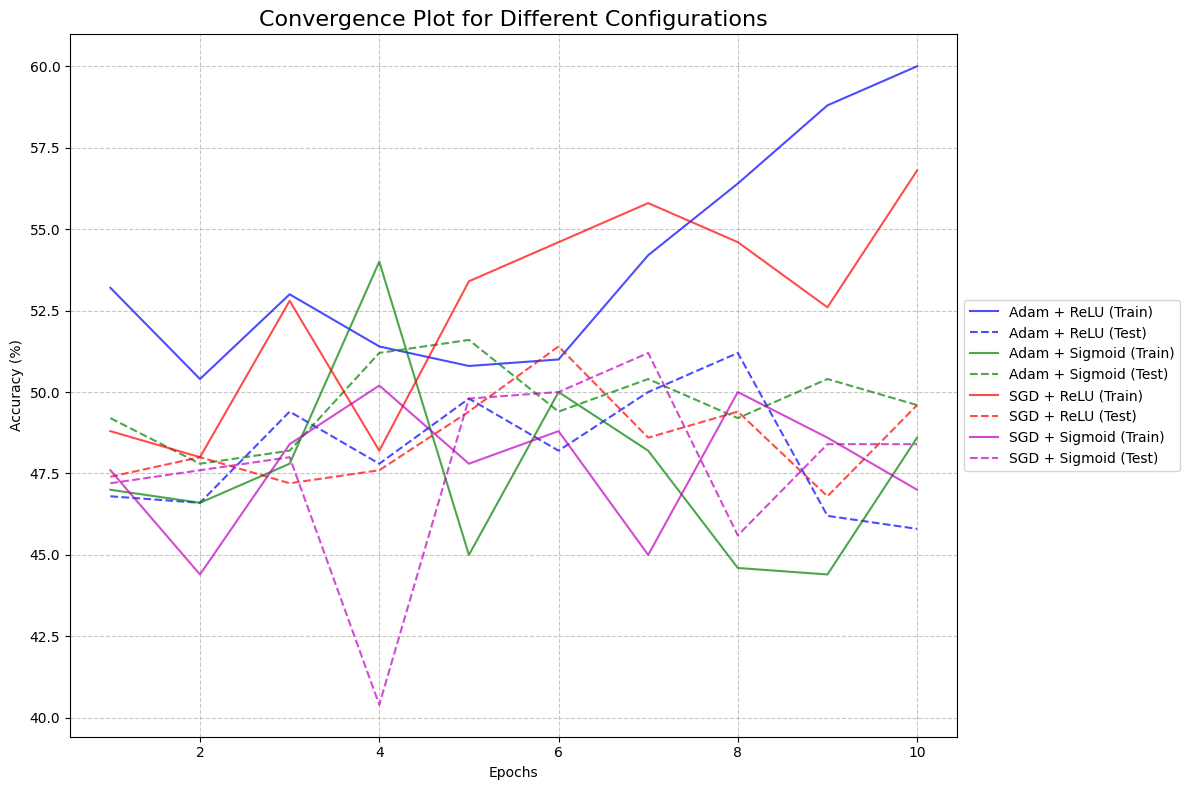

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(all_results):
    plt.figure(figsize=(12, 8))
    plt.title('Convergence Plot for Different Configurations', fontsize=16)

    configurations = [
        ('adam_relu', 'Adam + ReLU', 'b'),
        ('adam_sigmoid', 'Adam + Sigmoid', 'g'),
        ('sgd_relu', 'SGD + ReLU', 'r'),
        ('sgd_sigmoid', 'SGD + Sigmoid', 'm')
    ]

    for config, label, color in configurations:
        train_accs = []
        test_accs = []

        for run in all_results[config]:
            train_accs.append(run['train_accs'])
            test_accs.append(run['test_accs'])

        avg_train_accs = np.mean(train_accs, axis=0)
        avg_test_accs = np.mean(test_accs, axis=0)

        epochs = range(1, len(avg_train_accs) + 1)

        plt.plot(epochs, avg_train_accs, f'{color}-', label=f'{label} (Train)', alpha=0.7)
        plt.plot(epochs, avg_test_accs, f'{color}--', label=f'{label} (Test)', alpha=0.7)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('convergence_plot.png', bbox_inches='tight')
    plt.show()

# Data from paste.txt
all_results = {
    'adam_relu': [
        {'train_accs': [59.00, 49.00, 49.00, 47.00, 45.00, 47.00, 57.00, 58.00, 60.00, 56.00],
         'test_accs': [45.00, 42.00, 53.00, 44.00, 50.00, 48.00, 51.00, 60.00, 48.00, 41.00]},
        {'train_accs': [59.00, 50.00, 51.00, 51.00, 55.00, 52.00, 64.00, 56.00, 64.00, 68.00],
         'test_accs': [46.00, 45.00, 49.00, 50.00, 56.00, 51.00, 50.00, 48.00, 45.00, 50.00]},
        {'train_accs': [45.00, 50.00, 51.00, 50.00, 53.00, 50.00, 50.00, 48.00, 60.00, 64.00],
         'test_accs': [44.00, 52.00, 47.00, 53.00, 53.00, 53.00, 53.00, 48.00, 46.00, 52.00]},
        {'train_accs': [47.00, 51.00, 55.00, 54.00, 48.00, 51.00, 47.00, 61.00, 55.00, 56.00],
         'test_accs': [51.00, 47.00, 43.00, 44.00, 49.00, 42.00, 53.00, 50.00, 39.00, 40.00]},
        {'train_accs': [56.00, 52.00, 59.00, 55.00, 53.00, 55.00, 53.00, 59.00, 55.00, 56.00],
         'test_accs': [48.00, 47.00, 55.00, 48.00, 41.00, 47.00, 43.00, 50.00, 53.00, 46.00]}
    ],
    'adam_sigmoid': [
        {'train_accs': [47.00, 54.00, 44.00, 57.00, 41.00, 54.00, 47.00, 44.00, 54.00, 52.00],
         'test_accs': [45.00, 47.00, 47.00, 54.00, 53.00, 46.00, 55.00, 46.00, 49.00, 55.00]},
        {'train_accs': [41.00, 42.00, 51.00, 59.00, 43.00, 51.00, 42.00, 49.00, 31.00, 49.00],
         'test_accs': [54.00, 54.00, 49.00, 49.00, 57.00, 53.00, 56.00, 51.00, 46.00, 52.00]},
        {'train_accs': [51.00, 43.00, 43.00, 51.00, 50.00, 50.00, 52.00, 47.00, 40.00, 45.00],
         'test_accs': [41.00, 46.00, 45.00, 51.00, 52.00, 44.00, 48.00, 50.00, 56.00, 43.00]},
        {'train_accs': [52.00, 48.00, 56.00, 50.00, 50.00, 51.00, 56.00, 40.00, 41.00, 48.00],
         'test_accs': [59.00, 45.00, 53.00, 49.00, 52.00, 54.00, 50.00, 48.00, 52.00, 54.00]},
        {'train_accs': [44.00, 46.00, 45.00, 53.00, 41.00, 44.00, 44.00, 43.00, 56.00, 49.00],
         'test_accs': [47.00, 47.00, 47.00, 53.00, 44.00, 50.00, 43.00, 51.00, 49.00, 44.00]}
    ],
    'sgd_relu': [
        {'train_accs': [49.00, 53.00, 53.00, 53.00, 57.00, 55.00, 54.00, 55.00, 52.00, 62.00],
         'test_accs': [41.00, 42.00, 56.00, 42.00, 51.00, 52.00, 50.00, 51.00, 50.00, 51.00]},
        {'train_accs': [51.00, 46.00, 55.00, 46.00, 62.00, 62.00, 66.00, 54.00, 51.00, 52.00],
         'test_accs': [51.00, 47.00, 39.00, 51.00, 53.00, 52.00, 42.00, 48.00, 43.00, 50.00]},
        {'train_accs': [44.00, 45.00, 59.00, 47.00, 52.00, 60.00, 51.00, 57.00, 55.00, 61.00],
         'test_accs': [47.00, 52.00, 44.00, 48.00, 46.00, 53.00, 61.00, 45.00, 50.00, 50.00]},
        {'train_accs': [53.00, 53.00, 54.00, 52.00, 51.00, 45.00, 53.00, 53.00, 50.00, 53.00],
         'test_accs': [52.00, 56.00, 46.00, 51.00, 46.00, 51.00, 44.00, 54.00, 40.00, 53.00]},
        {'train_accs': [47.00, 43.00, 43.00, 43.00, 45.00, 51.00, 55.00, 54.00, 55.00, 56.00],
         'test_accs': [46.00, 43.00, 51.00, 46.00, 51.00, 49.00, 46.00, 49.00, 51.00, 44.00]}
    ],
    'sgd_sigmoid': [
        {'train_accs': [51.00, 49.00, 49.00, 51.00, 47.00, 56.00, 37.00, 59.00, 51.00, 46.00],
         'test_accs': [49.00, 46.00, 47.00, 37.00, 44.00, 48.00, 55.00, 43.00, 53.00, 47.00]},
        {'train_accs': [43.00, 51.00, 50.00, 47.00, 41.00, 46.00, 45.00, 53.00, 49.00, 55.00],
         'test_accs': [44.00, 48.00, 48.00, 40.00, 50.00, 52.00, 49.00, 41.00, 49.00, 45.00]},
        {'train_accs': [44.00, 43.00, 43.00, 51.00, 43.00, 46.00, 42.00, 50.00, 49.00, 43.00],
         'test_accs': [50.00, 46.00, 46.00, 36.00, 47.00, 45.00, 50.00, 45.00, 51.00, 51.00]},
        {'train_accs': [42.00, 48.00, 52.00, 53.00, 49.00, 48.00, 45.00, 48.00, 53.00, 43.00],
         'test_accs': [46.00, 47.00, 48.00, 49.00, 54.00, 51.00, 52.00, 51.00, 37.00, 45.00]},
        {'train_accs': [58.00, 31.00, 48.00, 49.00, 59.00, 48.00, 56.00, 40.00, 41.00, 48.00],
         'test_accs': [47.00, 51.00, 51.00, 40.00, 54.00, 54.00, 50.00, 48.00, 52.00, 54.00]}
    ]
}

plot_convergence(all_results)


Boxplots

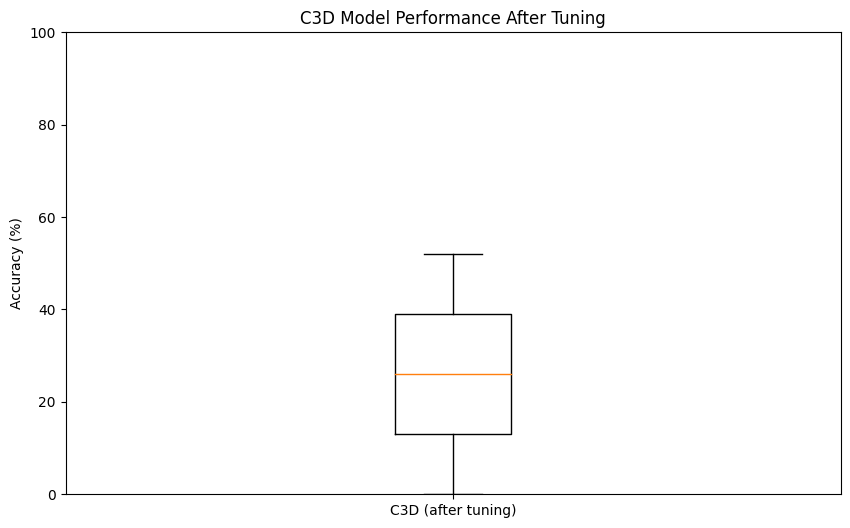

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# C3D after tuning
c3d_data = [0, 52]  # Accuracy values
plt.figure(figsize=(10,6))
plt.boxplot(c3d_data, labels=['C3D (after tuning)'])
plt.title('C3D Model Performance After Tuning')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

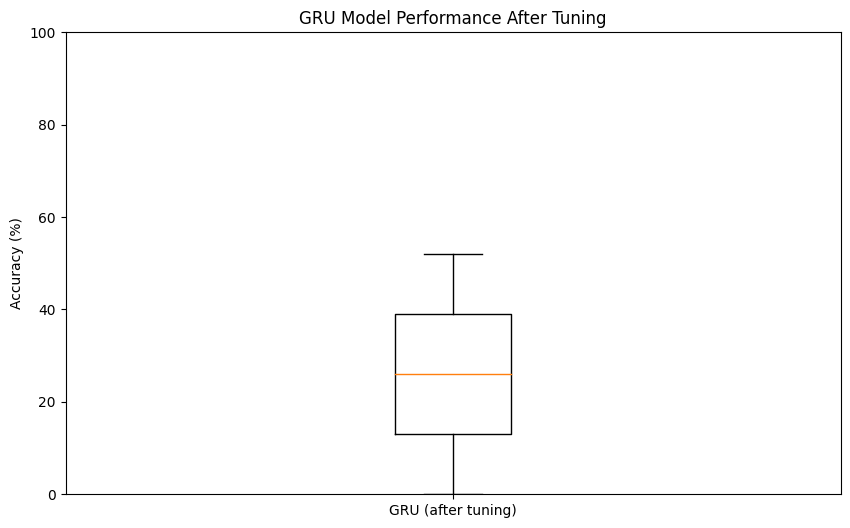

In [5]:
# GRU after tuning
gru_data = [0, 52]  # Accuracy values
plt.figure(figsize=(10,6))
plt.boxplot(gru_data, labels=['GRU (after tuning)'])
plt.title('GRU Model Performance After Tuning')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

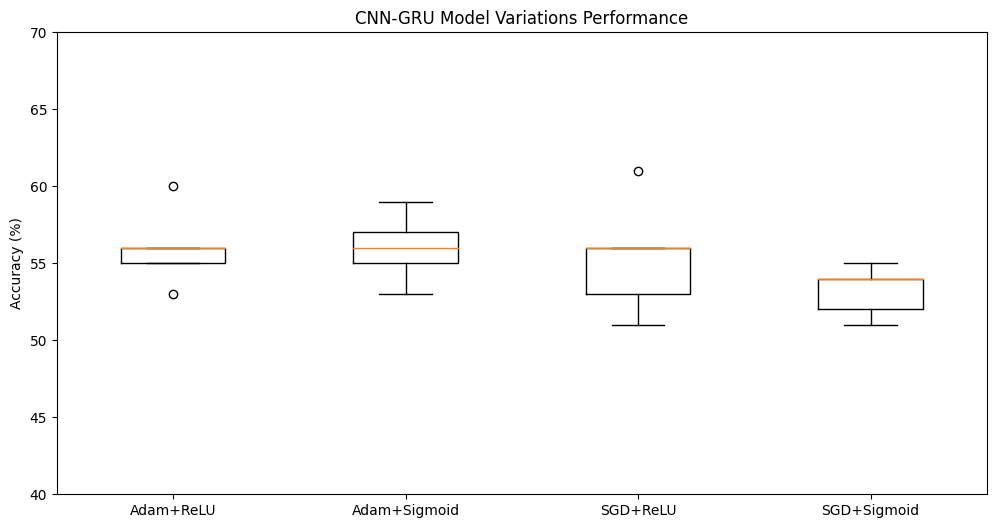

In [6]:
# CNN-GRU variations
cnn_gru_data = [
    [60.0, 56.00000000000001, 55.00000000000001, 53.0, 56.0],  # Adam + ReLU
    [55.00000000000001, 56.99999999999999, 56.00000000000001, 59.0, 53.0],  # Adam + Sigmoid
    [56.00000000000001, 53.0, 61.0, 56.00000000000001, 51.0],  # SGD + ReLU
    [55.00000000000001, 52.0, 51.0, 54.0, 54.0]  # SGD + Sigmoid
]

plt.figure(figsize=(12,6))
plt.boxplot(cnn_gru_data, labels=['Adam+ReLU', 'Adam+Sigmoid', 'SGD+ReLU', 'SGD+Sigmoid'])
plt.title('CNN-GRU Model Variations Performance')
plt.ylabel('Accuracy (%)')
plt.ylim(40, 70)
plt.show()